In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from vplot import colors
import astropy.units as u
import rebound

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Eccentricity space

The following creates Fig. 1.

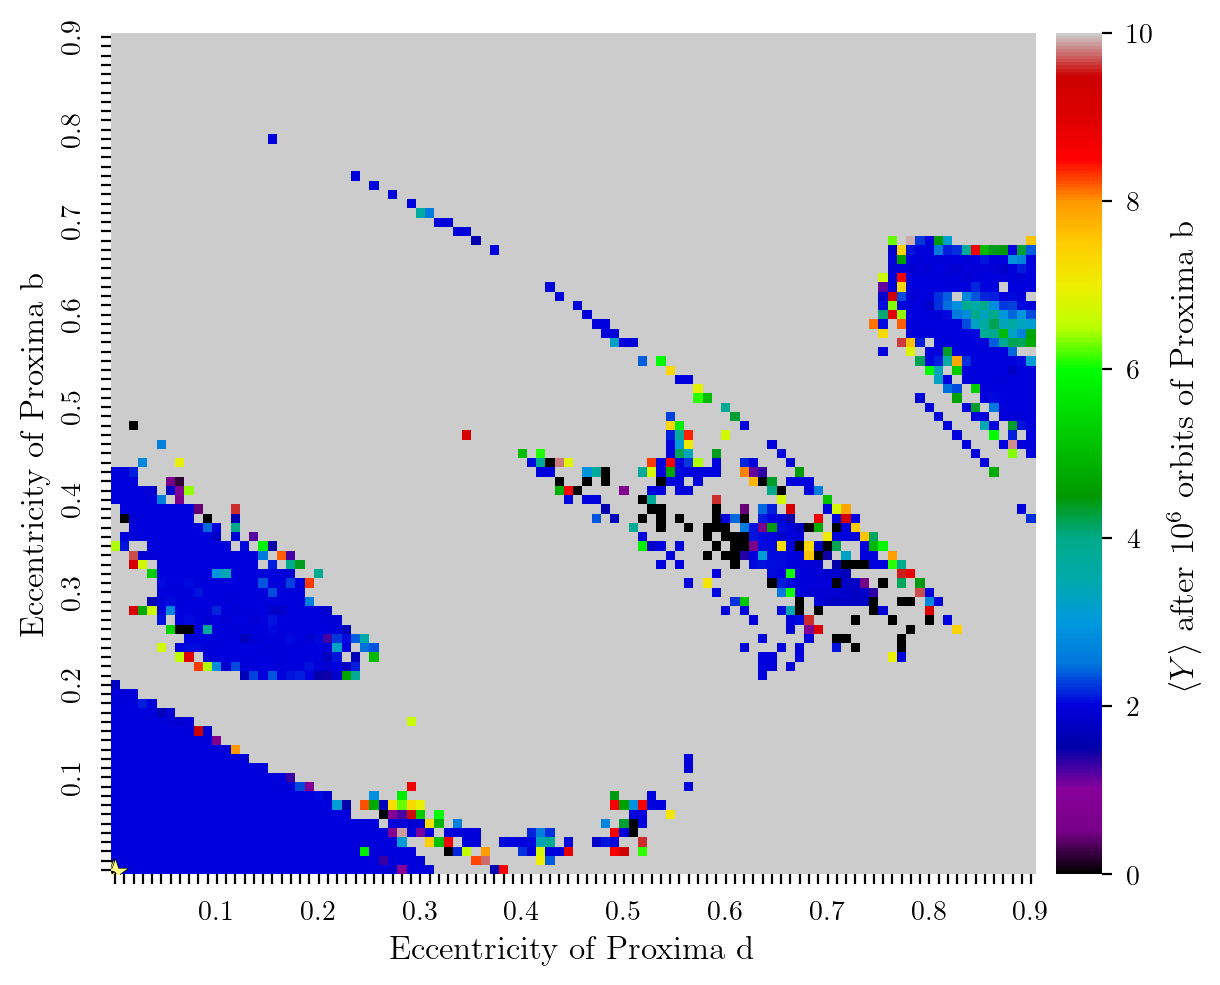

In [79]:
# megno_map_file = '~/Documents/GitHub/ProximaEvolution/hill-stability/ecc-megno-2.txt'
# megno_map_supp = '~/Documents/GitHub/ProximaEvolution/hill-stability/ecc-megno-supp.txt'
# hill_stab_file = '~/Documents/GitHub/ProximaEvolution/hill-stability/proxhillstabecc.txt'

megno_map_file = 'ecc-megno.txt'
megno_supp_file = None
hill_stab_file = 'proxhillstab.txt'

column_names = ['d_mass', 'b_mass', 'd_semi', 'b_semi', 'd_ecc', 'b_ecc', 'd_inc', 'b_inc', 'd_Omega', 'b_Omega', 'd_pomega', 'b_pomega', 'megno']
df = pd.read_csv(megno_map_file, sep=' ', names=column_names, index_col=False)

# Apply masks
stable_df = df.mask(np.fabs(df['megno'] - 2.) > 1.0e-2).mask(df['megno'] == 10.).dropna()
unstable_df = df.mask(np.fabs(df['megno'] - 2.) < 1.0e-2).mask(df['megno'] == 10.).dropna()
escape_df = df.mask(df['megno'] != 10.).dropna() # we arbitrarily set MEGNO to 10.0 where escape occurs

# Hill stability data (calculated with prox_hill_stab.c)
hill_stab_cols = ['exact', 'approx', 'd_mass', 'b_mass', 'd_semi', 'b_semi',
                'd_ecc', 'b_ecc', 'd_aper', 'b_aper', 'd_inc', 'b_inc',
                'd_lasc', 'b_lasc', 'd_mean_an', 'b_mean_an']
hillstab = pd.read_csv(hill_stab_file, sep=' ', names=hill_stab_cols, index_col=False)

# Cleaning up the data
df = df.drop_duplicates(subset=['d_ecc', 'b_ecc'])
if megno_map_supp != None:
    df_supp = pd.read_csv(megno_map_supp, sep=' ', names=column_names, index_col=False)
    df_supp = df_supp.drop_duplicates(subset=['d_ecc', 'b_ecc'])
    df = pd.concat([df, df_supp]).drop_duplicates(subset=['d_ecc', 'b_ecc'])

d_ecc_list = list(df['d_ecc'])
b_ecc_list = list(df['b_ecc'])
d_ecc = []
b_ecc = []
for de in d_ecc_list:
    if de not in d_ecc:
        d_ecc.append(de)
for be in b_ecc_list:
    if be not in b_ecc:
        b_ecc.append(be)
for de in d_ecc:
    for be in b_ecc:
        if df[(np.abs(df['d_ecc'] - de) <= 0.005) & (np.abs(df['b_ecc'] - be) <= 0.005)].index.tolist() == []:
            new_row = {'d_ecc': de, 'b_ecc': be, 'megno': 0.}
            df = df.append(new_row, ignore_index=True)
df = df.drop_duplicates(subset=['d_ecc', 'b_ecc'])
df = df.sort_values(by=['b_ecc', 'd_ecc'])

# Make MEGNO heatmap
megno_map = np.zeros((100, 91))
for k in range(len(df['megno'])):
    i = k % 100
    j = int(np.floor(k/100))
    m = df['megno'].iloc[k]
    if np.isnan(m):
        m = 10.
    megno_map[i][j] = m

# Assign quasi-periodic/chaotic/unstable designation
orbit_type = np.zeros((100, 91))
for k in range(len(df['megno'])):
    i = k % 100
    j = int(np.floor(k/100))
    if np.fabs(df['megno'].iloc[k] - 2.) <= 1e-2: # Criterion of Hinse et al. (2010)
        orbit_type[i][j] = 1. # quasi-periodic
    elif (df['megno'].iloc[k] == 10.) or (np.isnan(df['megno'].iloc[k])):
        orbit_type[i][j] = 0. # unstable -- ejection occurs
    elif df['megno'].iloc[k] == 0.:
        orbit_type[i][j] = 0.5 # no data -- for some reason, the simulation didn't finish
    else:
        orbit_type[i][j] = 0.5 # chaotic, but not necessarily unstable

# Make tick labels
d_tick_labels = np.round_(np.linspace(0., 0.9, 100), decimals=2)
b_tick_labels = np.round_(np.linspace(0., 0.9, 91), decimals=2)
d_tick_labels = [str(e) for e in d_tick_labels]
b_tick_labels = [str(e) for e in b_tick_labels]
for i, e in enumerate(d_tick_labels):
    if e not in str(np.linspace(0., 0.9, 10)):
        d_tick_labels[i] = ''
    else:
        d_tick_labels[i] = str(d_tick_labels[i])
for i, e in enumerate(b_tick_labels):
    if e not in str(np.linspace(0., 0.9, 10)):
        b_tick_labels[i] = ''
    else:
        b_tick_labels[i] = str(b_tick_labels[i])

X, Y = np.meshgrid(np.linspace(0.009, 0.9, 100), np.linspace(0., 0.9, 91))

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)
divider = make_axes_locatable(ax)
cmap = 'nipy_spectral'
cax = divider.append_axes('right', size='5%', pad=0.1)
with sns.axes_style('ticks'):
    hm = sns.heatmap(megno_map.T,
                     vmin=0.,
                     vmax=10.,
                     cmap='nipy_spectral',
                     xticklabels=d_tick_labels,
                     yticklabels=b_tick_labels,
                     square=True,
                     cbar=True,
                     cbar_kws={'label':r'$\langle Y \rangle$ after $10^6$ orbits of Proxima b'},
                     cbar_ax=cax,
                     ax=ax
                    )
# ax.contourf(X, Y, megno_map.T, cmap=cmap)
# cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax)
# cbar.set_label(r'$\langle Y \rangle$ after $10^6$ orbits of Proxima b')
# ax.contourf(X, Y, orbit_type.T, cmap='RdBu')
ax.tricontour(hillstab['d_ecc'],
              hillstab['b_ecc'],
              hillstab['exact'],
              levels=[1.],
              colors='k'
#               colors=colors.pale_blue
             )

# Limit of crossing orbits
# ax.plot(d_ecc, b_ecc_at_crossing, c='lime', ls='--')

# Locations of simulations in Fig. 2
ax.scatter([0.05, 0.3, 0.45], [0.05, 0.2, 0.3], marker='*', s=100, c='xkcd:pale yellow', edgecolor='k')
# ax.scatter([5., 30., 45.], [5., 20., 30.], marker='*', s=100, c='xkcd:pale yellow', edgecolor='k')

# Location of VPLanet simulation in AAS 241 presentation
# ax.scatter(0.0907129347973946, 0.09250015269796305, marker='*', s=200, c='xkcd:pale yellow', edgecolor='k')

ax.invert_yaxis()
ax.tick_params(which='minor', bottom=False, left=False)
ax.set_xlim(left=0.009)
ax.set_xlabel('Eccentricity of Proxima d')
ax.set_ylabel('Eccentricity of Proxima b');
# fig.savefig('varying-ecc.pdf', dpi=400, bbox_inches='tight')

## Sample simulations with output

The following creates Fig. 2. Note that the second cell below will run three REBOUND simulations that will last for several minutes each.

In [70]:
def phase_delta(d, b):
    """
    Calculate the separation in phase space between the two planets. This verifies the exponential
    increase in the separation for chaotic (MEGNO != 2) evolution.
    """
    xdiff = b.x - d.x
    ydiff = b.y - d.y
    zdiff = b.z - d.z
    vxdiff = b.vx - d.vx
    vydiff = b.vy - d.vy
    vzdiff = b.vz - d.vz
    phase_delta_vec = np.array([xdiff, ydiff, zdiff, vxdiff, vydiff, vzdiff])
    return np.linalg.norm(phase_delta_vec)

def conjunction_longitude(d, b):
    return (2.*b.l - d.l) % (2.*np.pi)

def resonant_argument_1(d, b):
    return (2.*b.l - d.l - d.pomega) % (2.*np.pi)

def resonant_argument_2(d, b):
    return (2.*b.l - d.l - b.pomega) % (2.*np.pi)

def resonant_argument_3(d, b):
    return (3.*b.l - d.l - 2.*d.pomega) % (2.*np.pi)

def resonant_argument_32(d, b):
    return (3.*b.l - 2.*d.l - d.pomega) % (2.*np.pi)

def crossing_orbit(d, b):
    cross = False
    d_dist_at_d_apocenter = d.a * (1. - d.e**2.)
    b_dist_at_d_apocenter = b.a * (1. - b.e**2.) / (1. + b.e * np.cos(d.pomega - b.pomega + np.pi))
    if d_dist_at_d_apocenter > b_dist_at_d_apocenter:
        cross = True
    return cross

def simulation_with_output(par, integrator='ias15', num_orbit=1.0e6, step_size=100, primary_mass=0.12, M=None):
    """
    Runs a REBOUND simulation with the specified orbital elements for Proxima d & b. Returns DataFrame with
    snapshots of the orbital elements taken every 100 timesteps.
    """
    m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2 = par # unpack parameters
    sim = None
    sim = rebound.Simulation()
    sim.integrator = integrator
    if integrator == 'whfast':
        sim.ri_whfast.safe_mode = False
        sim.ri_whfast.corrector = 11
    sim.add(m=primary_mass)                      # Proxima Centauri
    if M == None:
        sim.add(m=m1, a=a1, e=e1, inc=i1, Omega=Omega1, pomega=pomega1)  # Proxima d
        sim.add(m=m2, a=a2, e=e2, inc=i2, Omega=Omega2, pomega=pomega2)  # Proxima b
    else:
        M1, M2 = M
        sim.add(m=m1, a=a1, e=e1, inc=i1, Omega=Omega1, pomega=pomega1, M=M1)  # Proxima d
        sim.add(m=m2, a=a2, e=e2, inc=i2, Omega=Omega2, pomega=pomega2, M=M2)  # Proxima b
    star = sim.particles[0]
    d = sim.particles[1]
    b = sim.particles[2]
    sim.dt = 0.05 * d.P # timestep is 5% of Proxima d's orbital period
#     sim.dt = 0.01 * d.P # For System A from Barnes et al. (2015)
    b_per = b.P
    orbits_cross = False
    sim.move_to_com()
    if integrator == 'ias15':
        sim.ri_ias15.min_dt = 1e-4 * sim.dt
    sim.init_megno()
    sim.exit_max_distance = 20.
    
    energy = sim.calculate_energy()
    delta = phase_delta(d, b)
    conj = conjunction_longitude(d, b)
    phi1 = resonant_argument_1(d, b)
    phi2 = resonant_argument_2(d, b)
    phi3 = resonant_argument_3(d, b)
    phi32 = resonant_argument_32(d, b)
    output = [[0., a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1,
               pomega2, d.l, b.l, 0., 0., 0., 0., energy, 0.,
               delta, conj, phi1, phi2, phi3, phi32]]
    
#     sim.integrate(num_orbit*b.P, exact_finish_time=False)
#     final_energy = sim.calculate_energy()
#     return energy, final_energy
    
    try:
        i = 0
        while sim.t <= num_orbit * b_per: # Integrate num_orbit orbits of Proxima b
            if i % 1000 == 0:
#                 print(sim.t/(2.*np.pi))
            sim.steps(step_size)
            do = d.calculate_orbit(primary=star)
            bo = b.calculate_orbit(primary=star)
            megno = sim.calculate_megno()
            energy = sim.calculate_energy()
            delta = phase_delta(d, b)
            conj = conjunction_longitude(do, bo)
            phi1 = resonant_argument_1(do, bo)
            phi2 = resonant_argument_2(do, bo)
            phi3 = resonant_argument_3(do, bo)
            phi32 = resonant_argument_32(do, bo)
            output.append([sim.t, do.a, bo.a, do.e, bo.e, do.inc, bo.inc, do.Omega, bo.Omega,
                           do.pomega, bo.pomega, do.l, bo.l, do.n, bo.n, do.d, bo.d, energy,
                           megno, delta, conj, phi1, phi2, phi3, phi32])
            if crossing_orbits(do, bo):
                orbits_cross = True
            i += 1
    except rebound.Escape as ex:
        print(ex)
    megno = sim.calculate_megno()
    print(orbits_cross)
    column_names = ['time', 'd_semi', 'b_semi', 'd_ecc', 'b_ecc', 'd_inc', 'b_inc', 'd_Omega', 'b_Omega',
                    'd_pomega', 'b_pomega', 'd_lambda', 'b_lambda', 'd_mm', 'b_mm', 'd_dist', 'b_dist',
                    'energy', 'megno', 'delta', 'conj', 'phi1', 'phi2', 'phi3', 'phi32']
    return pd.DataFrame(data=output, columns=column_names)

In [71]:
# Example case with quasi-periodic motion
e1 = 0.05
e2 = 0.05
min_mass1 = float(0.26 * u.earthMass/u.solMass)
min_mass2 = float(1.07 * u.earthMass/u.solMass)
obs_inc1 = 133.
obs_inc2 = 133.
m1 = min_mass1 / np.sin(obs_inc1)
m2 = min_mass2 / np.sin(obs_inc2)
a1 = 0.029
a2 = 0.049
i1 = 0.
i2 = 0.
Omega1 = 0.
Omega2 = np.pi
pomega1 = 0.
pomega2 = np.pi
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
stable_sim = simulation_with_output(par, integrator='whfast')

# Example case with chaotic motion 
e1 = 0.3
e2 = 0.2
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
chaotic_sim = simulation_with_output(par, integrator='whfast')

# Example case with ejection
e1 = 0.45
e2 = 0.3
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
unstable_sim = simulation_with_output(par)

0.0
71.2811589117059
142.5623178219847
213.84347673458691
285.1246356482254
356.4057945618639
427.68695347550243
498.9681123891409
570.2492713027794
641.5304302164179
712.8115891300563
784.0927480436949
855.3739069573334
926.6550658709718
997.9362247846103
1069.2173836982488
1140.4985426118874
1211.7797015255258
1283.0608604391643
1354.3420193528027
1425.623178266441
1496.9043371800797
1568.1854960937183
1639.4666550073566
1710.7478139209952
1782.0289728346336
1853.3101317482722
1924.5912906619105
1995.8724495755491
2067.1536084891877
2138.4347674028263
2209.7159263164644
2280.997085230103
2352.2782441437416
2423.55940305738
2494.840561971019
2566.121720884657
2637.402879774083
2708.6840386298213
2779.9651974855597
2851.246356341298
2922.5275151970363
2993.8086740527747
3065.0898329085126
3136.370991764251
3207.6521506199892
3278.9333094757276
3350.214468331466
3421.4956271872043
3492.776786042942
3564.0579448986805
3635.339103754419
3706.620262610157
3777.9014214658955
3849.1825803216

356.4057945618639
427.68695347550243
498.9681123891409
570.2492713027794
641.5304302164179
712.8115891300563
784.0927480436949
855.3739069573334
926.6550658709718
997.9362247846103
1069.2173836982488
1140.4985426118874
1211.7797015255258
1283.0608604391643
1354.3420193528027
1425.623178266441
1496.9043371800797
1568.1854960937183
1639.4666550073566
1710.7478139209952
1782.0289728346336
1853.3101317482722
1924.5912906619105
1995.8724495755491
2067.1536084891877
2138.4347674028263
2209.7159263164644
2280.997085230103
2352.2782441437416
2423.55940305738
2494.840561971019
2566.121720884657
2637.402879774083
2708.6840386298213
2779.9651974855597
2851.246356341298
2922.5275151970363
2993.8086740527747
3065.0898329085126
3136.370991764251
3207.6521506199892
3278.9333094757276
3350.214468331466
3421.4956271872043
3492.776786042942
3564.0579448986805
3635.339103754419
3706.620262610157
3777.9014214658955
3849.182580321634
3920.463739177372
3991.74489803311
4063.0260568888484
4134.307215744587
4

187.44940056708612
210.6629085081595
233.87293475657643
257.08469862683825
280.2974720164056
303.5073607798221
326.7203443507444
349.93185737877985
373.1419694987609
396.35558476962785
419.5661808345491
442.7768022056449
465.9904315863116
489.2005533926162
512.4119779167441
535.6250674594035
558.8349641241145
582.0475707357791
605.2595065712434
628.4694822499958
651.6830208987441
674.8938426411668
698.1042611075572
721.3179487641537
744.5282008551129
767.7393300082016
790.9526332663041
814.1625740788533
837.374768680256
860.5871233511355
883.7970430660179
907.0103106685771
930.221474693081
953.431703734257
976.6453846858212
999.8558109529505
1023.066660271849
1046.2801660636467
1069.4901877547763
1092.7020006329328
1115.914728937435
1139.1246389648559
1162.337648832231
1185.5491409721205
1208.7592380608141
1231.972893584445
1255.1834845151673
1278.3941225311728
1301.607720529031
1324.8178214371517
1348.0292608519699
1371.2423177588473
1394.452202654323
1417.6648010533518
1440.876750348

10655.878847722652
10679.092511156314
10702.302489384761
10725.514239195216
10748.727087640593
10771.937037166412
10795.15016148845
10818.361523260784
10841.571740331985
10864.785440027685
10887.995973018938
10911.206787683011
10934.420312690896
10957.630371322935
10980.842098903202
11004.054906153156
11027.264803640692
11050.477899510355
11073.689330563924
11096.899410405087
11120.113187312207
11143.323758562628
11166.534500797095
11189.748104239216
11212.958270964777
11236.16995727977
11259.382807755821
11282.592731905026
11305.805663058167
11329.017321626658
11352.227392592666
11375.44099596935
11398.651613214159
11421.862249821615
11445.075892535848
11468.285923126256
11491.497210267025
11514.710422949602
11537.920348924587
11561.132970512183
11584.344997195956
11607.555066436025
11630.768665297563
11653.979516137046
11677.189788393547
11700.403723045923
11723.613930813957
11746.825229190195
11770.038548736084
11793.248526144394
11816.461365455316
11839.673138293696
11862.883162738

20845.785959739023
20868.996627623197
20892.21040524655
20915.420567731828
20938.632017424883
20961.8453289477
20985.05549920464
21008.26847774438
21031.479951890455
21054.69030131962
21077.903933540798
21101.11444604931
21124.32534751998
21147.539067719714
21170.74905144259
21193.96170442849
21217.1741067168
21240.38449816424
21263.598241341035
21286.808529696016
21310.019000207274
21333.233099298694
21356.443164143748
21379.654422557942
21402.867682290413
21426.07780782443
21449.290940936047
21472.502324714405
21495.712624993343
21518.92653866723
21542.13728742285
21565.34876819186
21588.56210386452
21611.772201599328
21634.984766347654
21658.19715797558
21681.407725733075
21704.621313019474
21727.831732842915
21751.042572292827
21774.256426806918
21797.46630897512
21820.678871871438
21843.891327147576
21867.101385755308
21890.315737176104
21913.526088272167
21936.73678952669
21959.950308756415
21983.160370083195
22006.372453796197
22029.585215722345
22052.795530394847
22076.00886616

31082.16846303274
31105.38132582328
31128.591230134818
31151.80495957659
31175.016109328382
31198.226813206238
31221.440779710534
31244.65099532949
31267.863224681027
31291.07577340106


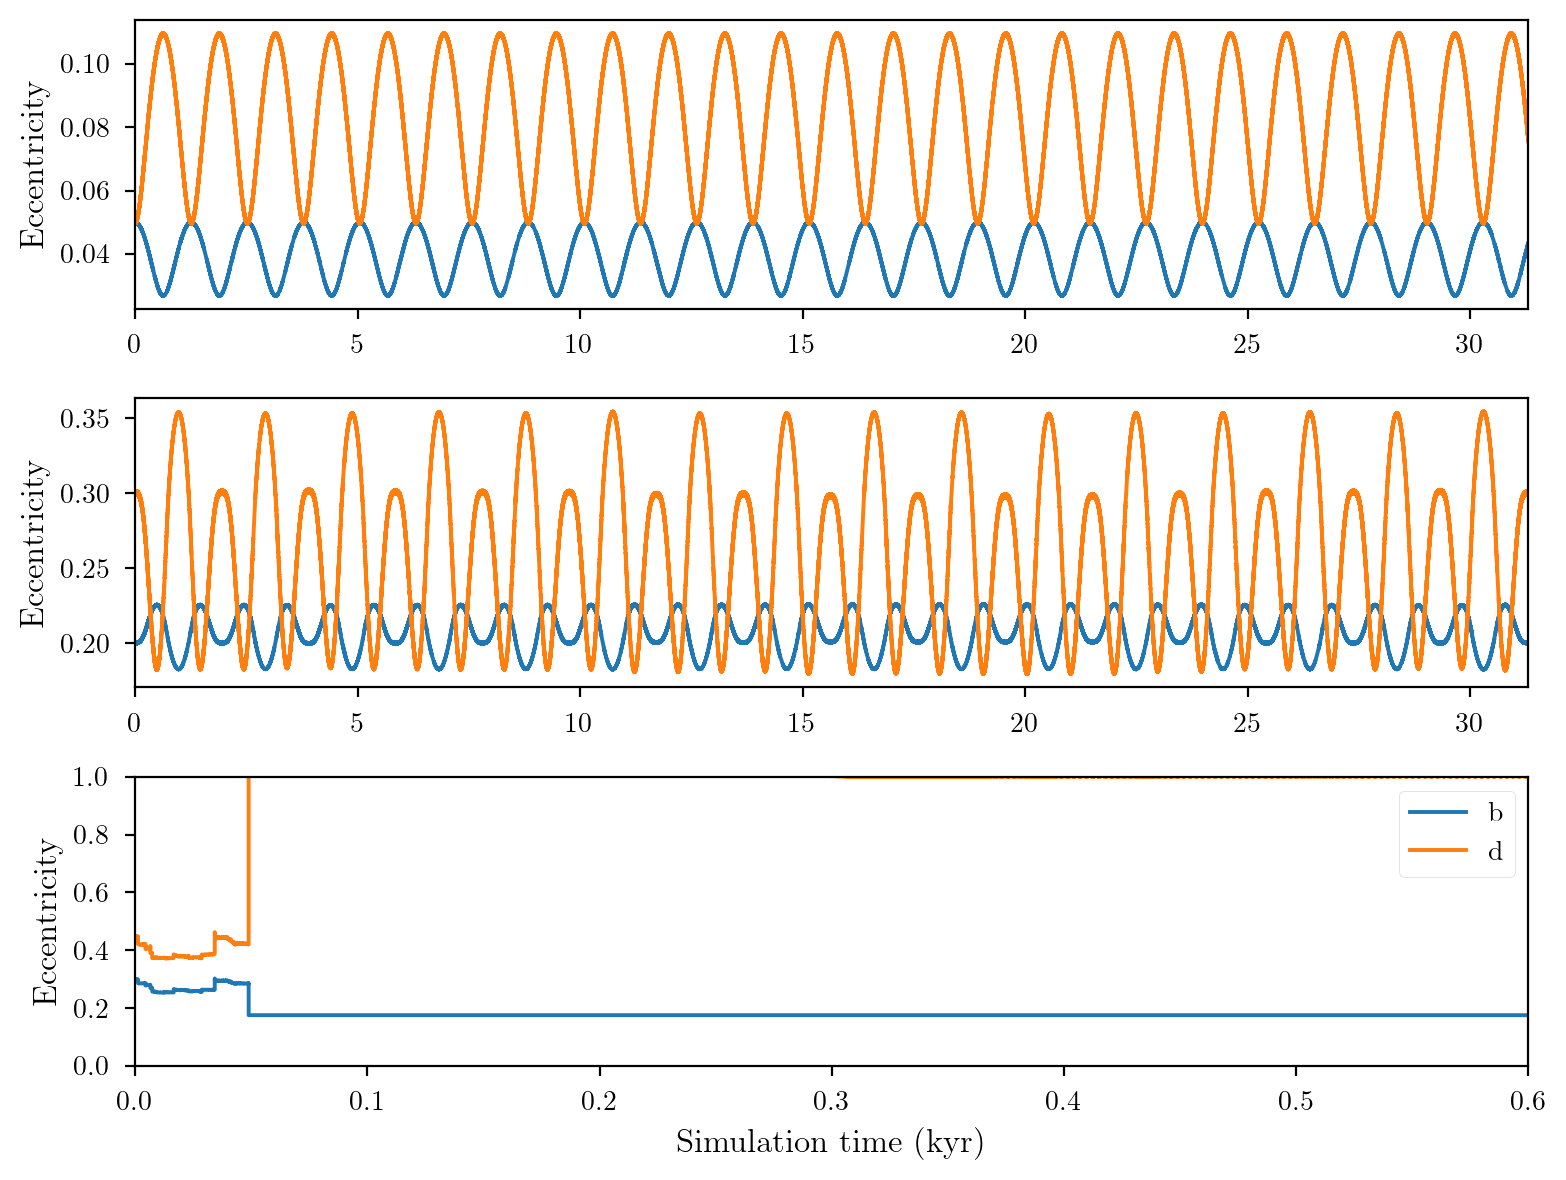

In [80]:
norm = 2. * np.pi * 1000. # conversion from REBOUND time units into kyr

fig, ax = plt.subplots(3, 1, figsize=(8, 6), dpi=200)
ax[0].plot(stable_sim['time']/norm, stable_sim['b_ecc'], label='b')
ax[0].plot(stable_sim['time']/norm, stable_sim['d_ecc'], label='d')
ax[1].plot(chaotic_sim['time']/norm, chaotic_sim['b_ecc'], label='b')
ax[1].plot(chaotic_sim['time']/norm, chaotic_sim['d_ecc'], label='d')
ax[2].plot(unstable_sim['time']/norm, unstable_sim['b_ecc'], label='b')
ax[2].plot(unstable_sim['time']/norm, unstable_sim['d_ecc'], label='d')
# ax[0].plot(stable_sim['time']/norm, stable_sim['b_semi'], label='b')
# ax[0].plot(stable_sim['time']/norm, stable_sim['d_semi'], label='d')
# ax[1].plot(chaotic_sim['time']/norm, chaotic_sim['b_semi'], label='b')
# ax[1].plot(chaotic_sim['time']/norm, chaotic_sim['d_semi'], label='d')
# ax[2].plot(unstable_sim['time']/norm, unstable_sim['b_semi'], label='b')
# ax[2].plot(unstable_sim['time']/norm, unstable_sim['d_semi'], label='d')
for a in ax:
    a.set_xlim(left=0.)
    a.set_ylabel('Eccentricity')
ax[2].set_xlabel('Simulation time (kyr)')
ax[0].set_xlim(right=max(stable_sim['time']/norm))
ax[1].set_xlim(right=max(chaotic_sim['time']/norm))
ax[2].set_xlim(right=0.6)
ax[2].set_ylim(top=1., bottom=0.)
ax[2].legend(loc=0);
# fig.savefig('evols-d05b05-d40b10-d30b50.pdf', bbox_inches='tight')

## Long-term (1 Myr) simulations

These data come from five Myr-length simulations with initial conditions in the apparent outlying quasi-periodic regions of Fig. 1. They may be generated by running the script `myr-sims.py`, but note that this will take several days to run. The initial conditions for each of these simulations are as follows.

* `sim1`: $e_d = 0.054, e_b = 0.36$
* `sim2`: $e_d = 0.162, e_b = 0.79$
* `sim3`: $e_d = 0.486, e_b = 0.58$
* `sim4`: $e_d = 0.675, e_b = 0.3$
* `sim5`: $e_d = 0.855, e_b = 0.56$

We observe some libration in the resonant arguments in only one case (`sim2`).

In [95]:
sim1 = pd.read_csv('myr-sim-0.054-0.36.csv')
sim2 = pd.read_csv('myr-sim-0.162-0.79.csv')
sim3 = pd.read_csv('myr-sim-0.486-0.58.csv')
sim4 = pd.read_csv('myr-sim-0.675-0.3.csv')
sim5 = pd.read_csv('myr-sim-0.855-0.56.csv')

In [96]:
names = ['sim1', 'sim2', 'sim3', 'sim4', 'sim5']
sims = [sim1, sim2, sim3, sim4, sim5]

def display_sim(Show):
    for i, name in enumerate(names):
        if Show == name:
            sim = sims[i]
            
    args = ['conj', 'phi1', 'phi3', 'phi32']
    labels = [r'$\lambda_c$', r'$\phi_{2:1}$', r'$\phi_{3:1}$', r'$\phi_{3:2}$']
    ticks = np.array([0., 1., 2.]) * np.pi
    num_plots = 4

    fig, ax = plt.subplots(num_plots, 1, figsize=(5, 6), dpi=200)
    for n in range(num_plots):
        ax[n].scatter(sim['time']/(2.*np.pi), sim[args[n]], c='k', s=0.1)
        ax[n].set_yticks(ticks, ['0', r'$\pi$', r'$2\pi$'])
        ax[n].set_ylabel(labels[n])
        ax[n].set_xlim(0.0e5, 0.1e5)
    ax[num_plots-1].set_xlabel('Simulation time (yr)');

interact(display_sim, Show=names);

interactive(children=(Dropdown(description='Show', options=('sim1', 'sim2', 'sim3', 'sim4', 'sim5'), value='si…

Note that $\lambda_c$ here is the longitude of conjunction, $\lambda_c \equiv 2\lambda' - \lambda$.

The MEGNO after 1 Myr tends away from 2 in each of these cases, indicating that the ones initially found to be quasi-periodic evolve towards chaos later on. This provides further evidence that the outlying islands of apparent stability in Fig. 1 are likely spurious.

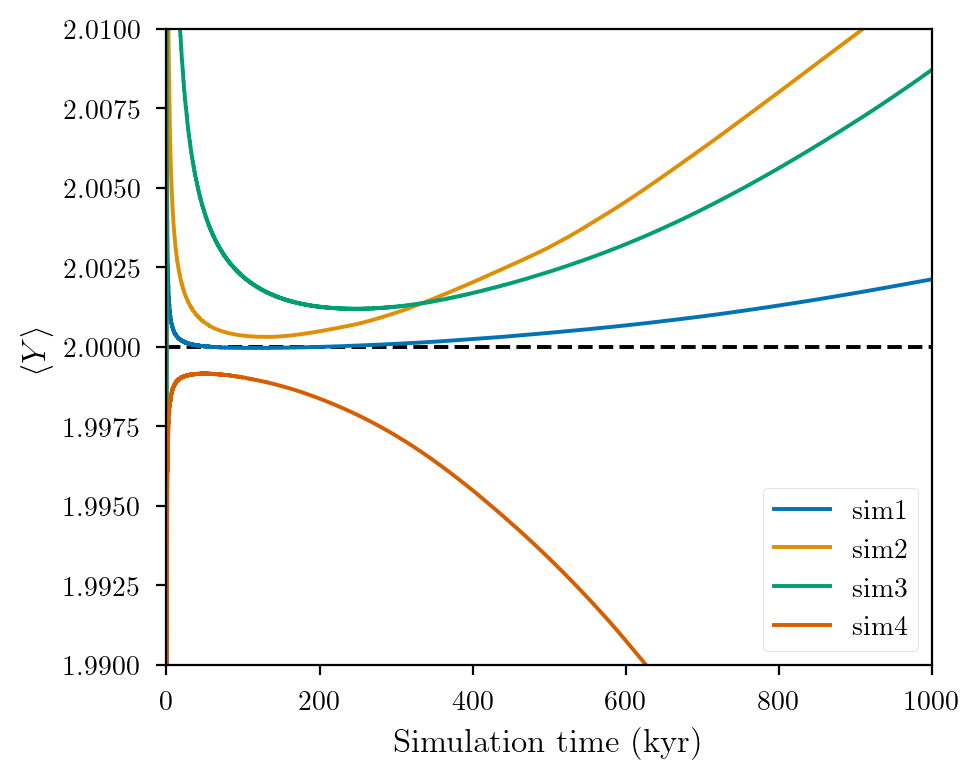

In [60]:
sims = [sim1, sim2, sim3, sim4]
names = ['sim1', 'sim2', 'sim3', 'sim4']
colors = sns.color_palette(palette='colorblind', n_colors=4)

fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
ax.axhline(y=2., ls='--', c='k')
for i, sim in enumerate(sims):
    ax.plot(sim['time']/(2.*np.pi*1000.), sim['megno'], label=names[i], c=colors[i])
ax.set_xlim(0., 1000.)
ax.set_ylim(1.99, 2.01)
# sim = sim1
# ecc_var = np.abs(sim['b_ecc']/sim['b_ecc'][0] - 1.)
# ax.plot(sim['time']/(2.*np.pi*1000.), ecc_var, label=names[i], c=colors[i])
ax.set_xlabel('Simulation time (kyr)')
ax.set_ylabel(r'$\langle Y \rangle$')
ax.legend(loc=4);

After 1 Myr, $|\ddot{\langle Y \rangle}| > 0$ in each case.

# Planetary mass space

These data are referenced in Sect. 3 (Set II of the simulations).

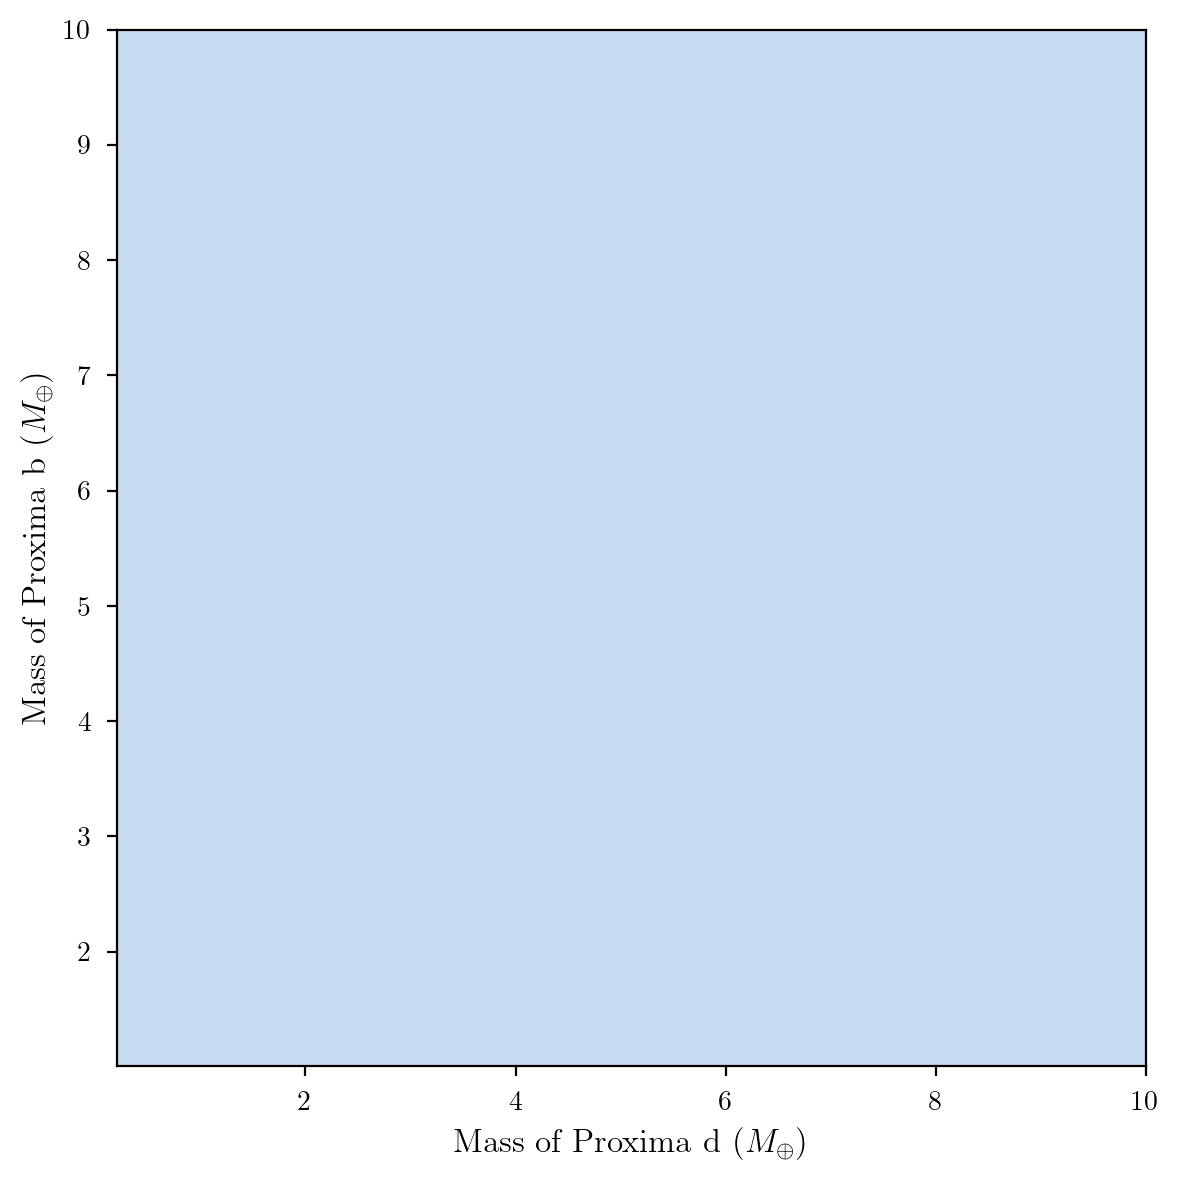

In [6]:
# megno_map_file = '~/Documents/GitHub/ProximaEvolution/hill-stability/mass-megno.txt'

megno_map_file = 'mass-megno.txt'

df = pd.read_csv(megno_map_file, sep=' ', names=column_names, index_col=False)

# Apply masks
stable_df = df.mask(np.fabs(df['megno'] - 2.) > 1.0e-2).dropna()
unstable_df = df.mask(np.fabs(df['megno'] - 2.) < 1.0e-2).dropna()
escape_df = df.mask(df['megno'] != 10.).dropna() # we arbitrarily set MEGNO to 10.0 where escape occurs

df = df.sort_values(by=['b_mass', 'd_mass'])

orbit_type = np.zeros((100, 100))
for k in range(len(df['megno'])):
    j = k % 100
    i = int(np.floor(k/100))
    if np.fabs(df['megno'].iloc[k] - 2.) <= 1e-2: # Criterion of Hinse et al. (2010)
        orbit_type[i][j] = 1. # quasi-periodic
    elif df['megno'].iloc[k] == 10.:
        orbit_type[i][j] = 0. # unstable -- ejection occurs
    else:
        orbit_type[i][j] = 0.5 # chaotic, but not necessarily unstable

# eccs = np.round_(np.linspace(0., 0.9, 100), decimals=2)
# ax = sns.heatmap(orbit_type, vmin=0., vmax=1., cmap='RdBu', xticklabels=[], yticklabels=[])
# ax.invert_yaxis();

X, Y = np.meshgrid(np.linspace(0.21, 10., 100), np.linspace(1.01, 10., 100))

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)
ax.contourf(X, Y, orbit_type.T, cmap='Blues')
ax.set_xlabel(r'Mass of Proxima d ($M_\oplus$)')
ax.set_ylabel(r'Mass of Proxima b ($M_\oplus$)');

# plt.savefig('mass.png', dpi=400)

Note that the color here has no real significance. Every case displayed is quasi-periodic. An all-blue colormap was chosen to agree perceptually with the quasi-periodic cases in the previous figure.

# Inclination space

The following creates Fig. 3.

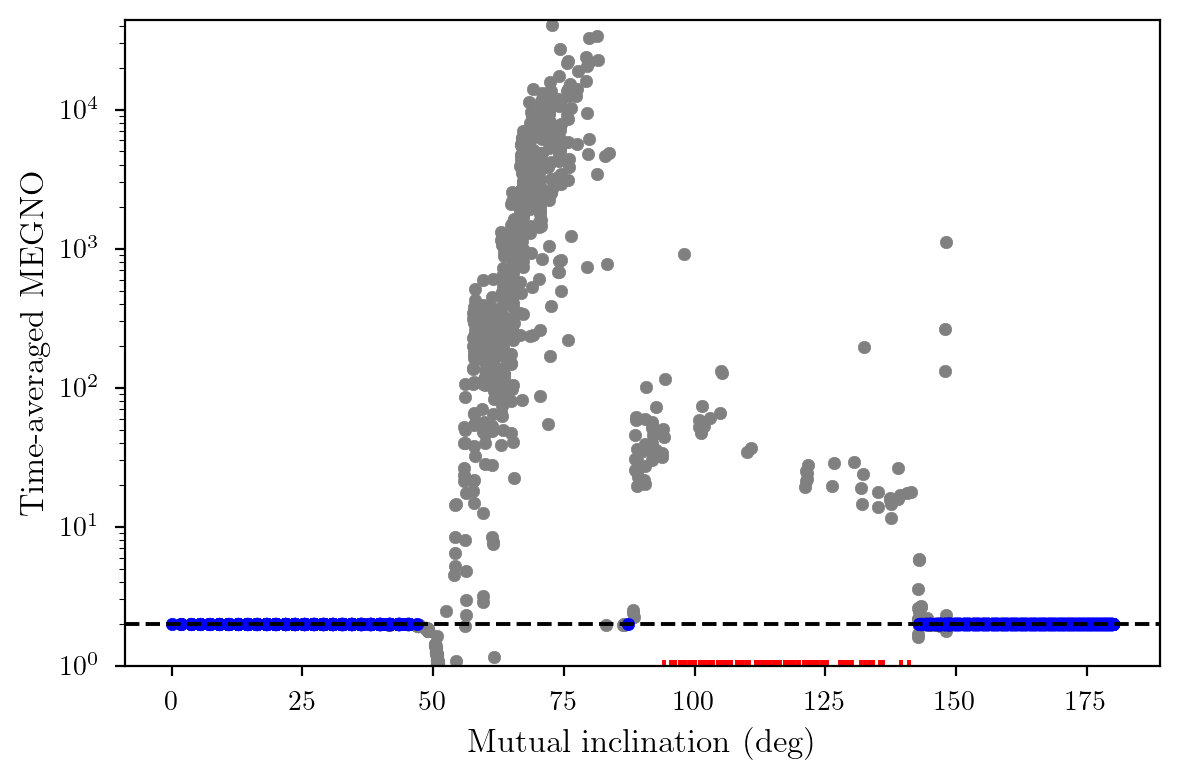

In [7]:
# megno_map_file = '~/Documents/GitHub/ProximaEvolution/hill-stability/inc-megno-2.txt'

megno_map_file = 'inc-megno.txt'

def mutual_inc(inc1, inc2, lasc1, lasc2):
    cosPsi = np.sin(inc1) * np.sin(inc2) * np.cos(lasc1 - lasc2) + np.cos(inc1) * np.cos(inc2)
    return np.arccos(cosPsi) * 180./np.pi

df = pd.read_csv(megno_map_file, sep=' ', names=column_names, index_col=False)

# Apply masks
periodic_df = df.mask(np.fabs(df['megno'] - 2.) > 1.0e-2).mask(df['megno'] == 10.).dropna()
chaotic_df = df.mask(np.fabs(df['megno'] - 2.) < 1.0e-2).mask(df['megno'] == 10.).dropna()
escape_df = df.mask(df['megno'] != 10.).dropna() # we arbitrarily set MEGNO to 10.0 where escape occurs

periodic_mutual_incs = mutual_inc(periodic_df['d_inc'], periodic_df['b_inc'], periodic_df['d_Omega'], periodic_df['b_Omega'])
chaotic_mutual_incs = mutual_inc(chaotic_df['d_inc'], chaotic_df['b_inc'], chaotic_df['d_Omega'], chaotic_df['b_Omega'])
escape_mutual_incs = mutual_inc(escape_df['d_inc'], escape_df['b_inc'], escape_df['d_Omega'], escape_df['b_Omega'])
escape_ticks = np.ones_like(escape_df['megno'])

fig, ax = plt.subplots(1, 1, dpi=200)
# ax.scatter(bound_mutual_incs, bound_df['megno'], s=20)
ax.scatter(escape_mutual_incs, escape_ticks, s=20, marker='|', c='r')
ax.scatter(chaotic_mutual_incs, chaotic_df['megno'], s=20, c='gray')
ax.scatter(periodic_mutual_incs, periodic_df['megno'], s=20, c='b')
ax.axhline(2., c='k', ls='--')
ax.set_ylim(bottom=1.)
ax.set_yscale('log')
ax.set_xlabel(r'Mutual inclination (deg)')
ax.set_ylabel('Time-averaged MEGNO');
# fig.savefig('mutual-incs.pdf', dpi=400, bbox_inches='tight');

In the range $95^\circ < \Psi < 142^\circ$, roughly $80\%$ of simulated cases result in instabilities.

In [8]:
num_chaos = len(chaotic_mutual_incs.mask(chaotic_mutual_incs > 142.).mask(chaotic_mutual_incs < 95.).dropna())
num_eject = len(escape_mutual_incs.mask(escape_mutual_incs > 142.).mask(escape_mutual_incs < 95.).dropna())
num_eject / (num_eject + num_chaos)

0.8159203980099502

In [81]:
# Example case with quasi-periodic motion (Psi = 3 deg)
e1 = 0.
e2 = 0.
min_mass1 = float(0.26 * u.earthMass/u.solMass)
min_mass2 = float(1.07 * u.earthMass/u.solMass)
obs_inc1 = 133. * np.pi/180.
obs_inc2 = 133. * np.pi/180.
m1 = min_mass1 / np.sin(obs_inc1)
m2 = min_mass2 / np.sin(obs_inc2)
a1 = 0.029
a2 = 0.049
i1 = 5. * np.pi/180.
i2 = 2. * np.pi/180.
Omega1 = 0.
Omega2 = 0.
pomega1 = 0.
pomega2 = np.pi
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
inc_stable_sim = simulation_with_output(par, integrator='whfast')

# Example case with chaotic motion (Psi = 60 deg)
i1 = 20. * np.pi/180.
i2 = 30. * np.pi/180.
Omega2 = np.pi
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
inc_chaotic_sim = simulation_with_output(par, integrator='whfast')

# Example case with ejection (Psi = 110 deg)
i1 = 10. * np.pi/180.
i2 = 100. * np.pi/180.
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
inc_unstable_sim = simulation_with_output(par)

0.0
71.28110869058433
142.56221737965026
213.8433260710396
285.1244347634652
356.4055434527985
427.6866521379866
498.9677608231747
570.2488695083628
641.5299781935508
712.811086878739
784.0921955639271
855.3733042491152
926.6544129343034
997.9355216194915
1069.2166303046795
1140.4977389898677
1211.7788476750559
1283.0599563602439
1354.3410650659598
1425.6221737800981
1496.9032824942362
1568.1843912083746
1639.4654999225127
1710.746608636651
1782.027717350789
1853.3088260649274
1924.5899347790655
1995.8710434932038
2067.152152207342
2138.4332609214803
2209.7143696356184
2280.9954783497565
2352.276587063895
2423.557695778033
2494.838804492171
2566.1199132063093
2637.4010219204474
2708.6821306345855
2779.963239348724
2851.244348062862
2922.5254567770003
2993.8065654911384
3065.087674205277
3136.368782919415
3207.649891633553
3278.931000347691
3350.21210906183
3421.493217775968
3492.774326490106
3564.0554352042445
3635.3365439183826
3706.6176526325207
3777.898761346659
3849.1798700607974
3

356.4055434527985
427.6866521379866
498.9677608231747
570.2488695083628
641.5299781935508
712.811086878739
784.0921955639271
855.3733042491152
926.6544129343034
997.9355216194915
1069.2166303046795
1140.4977389898677
1211.7788476750559
1283.0599563602439
1354.3410650659598
1425.6221737800981
1496.9032824942362
1568.1843912083746
1639.4654999225127
1710.746608636651
1782.027717350789
1853.3088260649274
1924.5899347790655
1995.8710434932038
2067.152152207342
2138.4332609214803
2209.7143696356184
2280.9954783497565
2352.276587063895
2423.557695778033
2494.838804492171
2566.1199132063093
2637.4010219204474
2708.6821306345855
2779.963239348724
2851.244348062862
2922.5254567770003
2993.8065654911384
3065.087674205277
3136.368782919415
3207.649891633553
3278.931000347691
3350.21210906183
3421.493217775968
3492.774326490106
3564.0554352042445
3635.3365439183826
3706.6176526325207
3777.898761346659
3849.1798700607974
3920.4609787749355
3991.7420874890736
4063.0231962032117
4134.30430491735
4205

378.5513170885643
416.40523711013225
454.25235937975174
492.0987732788348
529.9454834848028
567.789007748636
605.6250444406368
643.4530105000813
681.2735932670412
719.0875939383334
756.8922543687761
794.6851009410628
832.468470068071
870.2464899205667
908.0198187721484
945.7922554796082
983.5440415839414
1021.2392353953343
1058.8150716091277
1096.1713234349443
1133.1192259824559
1169.3170297725203
1204.7652670894236
1239.4682509614927
1273.440808406111
1306.6998310727888
1339.2634833680554
1371.1545701208622
1402.3881418706326
1432.9808161649205
1462.945728898112
1492.2991214075973
1521.054252542419
1549.226901176036
1576.7992817563381
1603.7259999162602
1630.0086912392217
1655.5587280839557
1680.2426351154313
1704.0828743869688
1727.111348112393
1749.3603647891184
1770.8650625918451
1791.652803581058
1811.7572632631834
1831.2130909361986
1850.040645262303
1868.240245335831
1885.8202009736883
1902.793182167168
1919.187930761576
1935.0333742539012
1950.2814315358885
1964.955711724604
19

5792.466525677862
5806.115657355977
5819.399839003478
5832.355038207545
5845.015833888303
5857.417327291982
5869.576379557409
5881.51694947891
5893.2584594340315
5904.823079606418
5916.2315221273875
5927.4820747215745
5938.567230185581
5949.484479405277
5960.242234436715
5970.849104321308
5981.312866556221
5991.641473958567
6001.846437031979
6011.93172736083
6021.911702471765
6031.799904459733
6041.603152682517
6051.327560946561
6060.982441928107
6070.5896321799555
6080.1444393382635
6089.6644798587195
6099.163129033208
6108.640705274119
6118.1162991071815
6127.594425275745
6137.076897458577
6146.577900609786
6156.095163042932
6165.657384268056
6175.282283681237
6184.990879542246
6194.8015362179995
6204.730760913684
6214.809042613721
6225.044354834185
6235.468963864522
6246.094175478851
6256.954396927612
6268.064838731309
6279.46974491902
6291.189207004748
6303.270048849511
6315.7524679260905
6328.695308381289
6342.147132968578
6356.166103510116
6370.806260182886
6386.176260405431
6402

10616.818548471978
10623.418400246632
10629.827463239722
10636.05046247225
10642.10873784065
10648.009637172021
10653.756772026401
10659.371329992198
10664.84602338878
10670.205820046463
10675.451896863638
10680.59802513775
10685.64469896794
10690.605964983115
10695.507268704696
10700.34226800366
10705.13220302353
10709.887887532379
10714.626617816612
10719.359531610311
10724.105253964415
10728.868039393183
10733.668300786183
10738.518767360523
10743.423304418684
10748.412605079693
10753.475934603584
10758.648295608487
10763.92280065539
10769.304658754238
10774.813937538836
10780.445638769277
10786.231637575682
10792.163135140729
10798.25146667154
10804.523343483183
10810.973279410593
10817.623629210866
10824.469159089618
10831.538992259455
10838.837969190352
10846.379274475827
10854.176584777102
10862.24442271876
10870.585861054415
10879.227354686866
10888.177280979928
10897.453522483765
10907.064495927552
10917.029194257448
10927.363960688308
10938.084037006873
10949.207184012468
109

15102.763680396967
15111.116817835627
15119.368564082062
15127.557869089937
15135.694188485566
15143.787688099856
15151.872680282822
15159.958862734231
15168.0608787929
15176.200740560542
15184.407331739278
15192.682674890786
15201.067577257241
15209.569743874796
15218.214053544069
15227.032917860597
15236.04057955216
15245.263793578315
15254.728827781055
15264.462877553005
15274.499874485045
15284.876554746852
15295.622912916584
15306.73775187873
15318.225199637289
15330.087028451706
15342.336070725216
15354.992112081794
15368.051804998775
15381.537081420573
15395.446127692352
15409.787695518065
15424.53679750795
15439.664338564597
15455.151022090255
15470.942850648848
15487.049239264088
15503.471136396613
15520.21469306919
15537.284170375522
15554.689330157573
15572.455965521907
15590.581698587263
15609.07173815483
15627.890267240637
15646.939340547322
15666.047298266034
15684.996003656015
15703.585524347323
15721.695791929405
15739.2665164633
15756.292658166843
15772.777559008302
15

19404.459791081303
19413.87840083417
19423.66006890986
19433.832396825157
19444.40412016242
19455.398878962827
19466.83364080967
19478.72769606058
19491.093486344955
19503.949898873885
19517.30621188148
19531.176750749924
19545.568939038585
19560.483218160458
19575.911377853387
19591.81576850383
19608.144696430307
19624.86374992242
19641.895194556055
19659.150689005623
19676.531157805373
19693.926974814825
19711.224598360033
19728.32525152639
19745.12881019173
19761.560228007867
19777.559842589922
19793.08502184047
19808.084952595516
19822.551203235693
19836.479745649838
19849.87851247597
19862.75729256601
19875.134936691644
19887.024923874742
19898.44744265148
19909.418564033225
19919.954876268876
19930.07773679501
19939.808081657302
19949.155177542307
19958.14794843315
19966.788492090473
19975.10113379447
19983.09989917288
19990.797280371797
19998.20986250992
20005.350044856972
20012.22364291539
20018.848018212724
20025.237524213382
20031.39876938815
20037.343773403947
20043.07801526

24032.328255853896


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/rebound/simulation.py:935: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


24035.856738628507
24039.730369715737
24044.493243488552
24049.22228898287
24053.93109316977
24058.624059081325
24063.304870109267
24068.04610831772
24072.950448080166
24078.093552493843
24083.45920166009
24089.04862232891
24094.860362730127
24100.931552807888
24107.22711443998
24113.770118826644
24120.582585249715
24127.644815386506
24134.988412491977
24142.614222107597
24150.52455257629
24158.755730407884
24167.309799378694
24176.18834816063
24185.428426992294
24195.03690763771
24205.03846567033
24215.44517189991
24226.269449504412
24237.551736147117
24249.30248014467
24261.53169175847
24274.280416585974
24287.542636748287
24301.35551668963
24315.71719506544
24330.649467879168
24346.149714651223
24362.22667922487
24378.842963181014
24395.959395064434
24413.496781581212
24431.371857298847
24449.463607824015
24467.62446095742
24485.717855273775
24503.598161592054
24521.151823694472
24538.281883149368
24554.922964684294
24571.01252549683
24586.541251306713
24601.49448204375
24615.880768

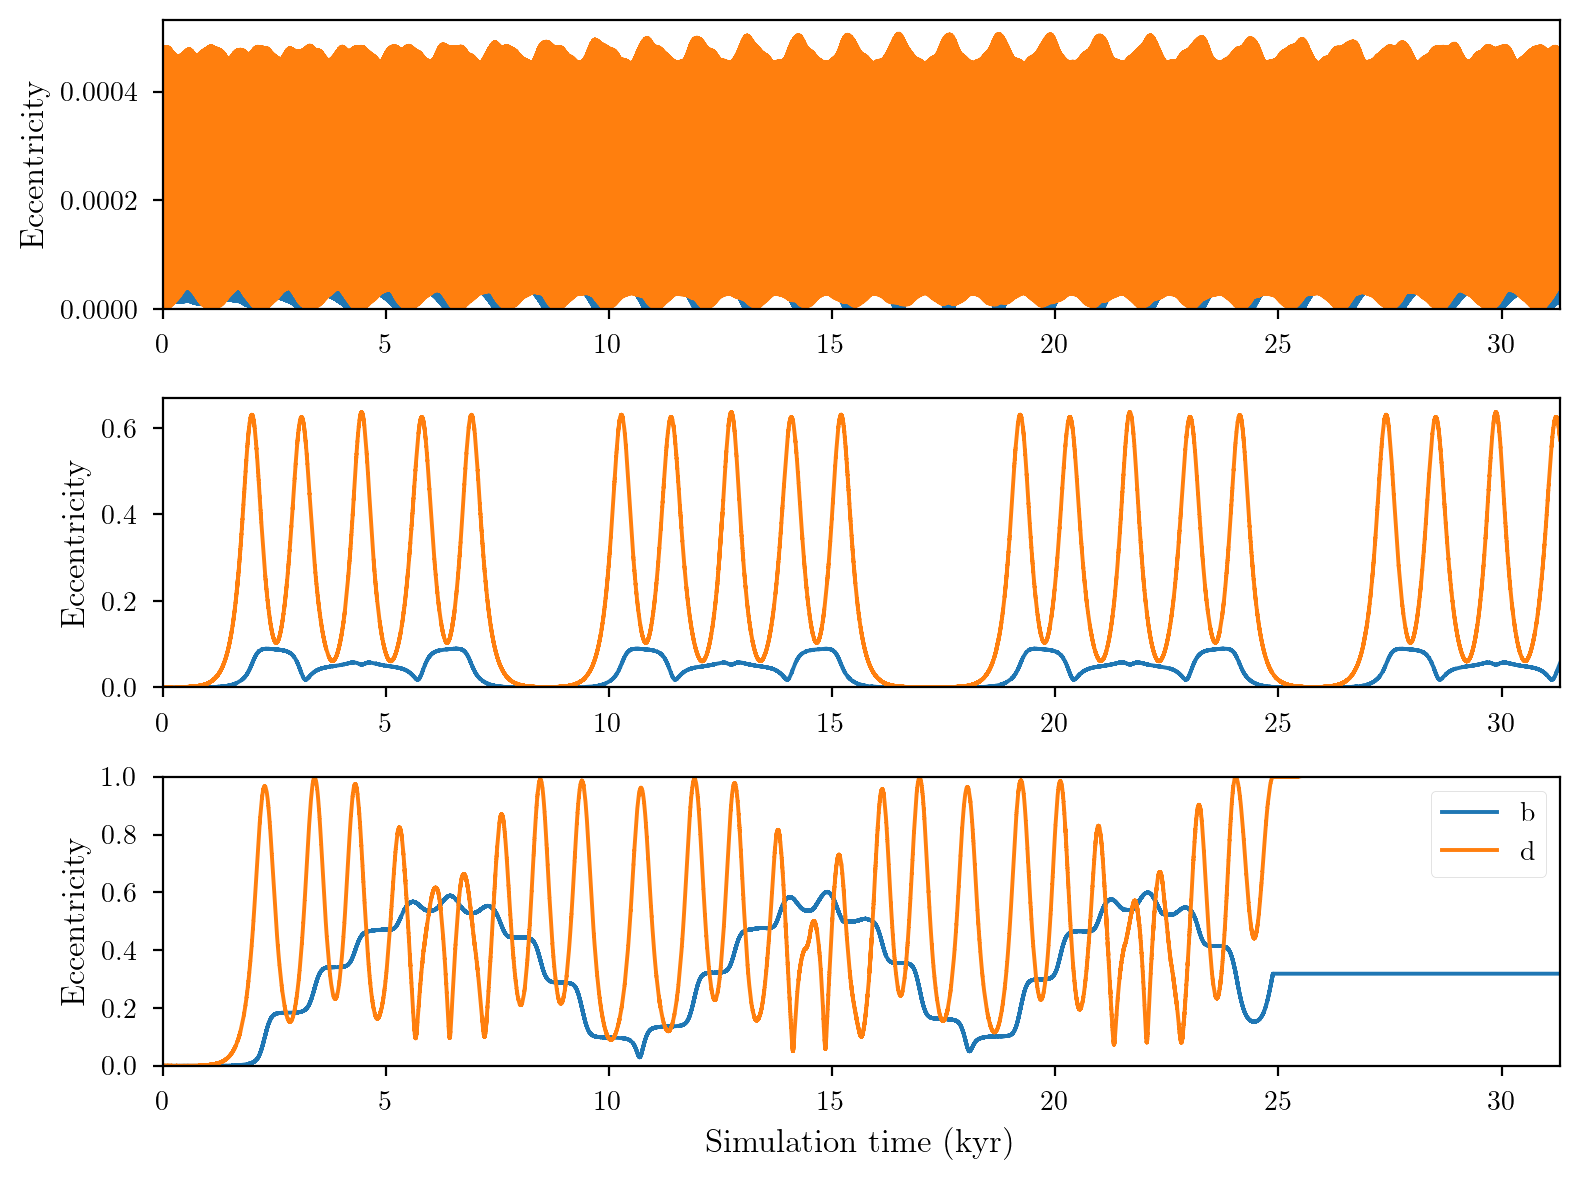

In [93]:
norm = 2. * np.pi * 1000. # conversion from REBOUND time units into kyr

fig, ax = plt.subplots(3, 1, figsize=(8, 6), dpi=200)
ax[0].plot(inc_stable_sim['time']/norm, inc_stable_sim['b_ecc'], label='b')
ax[0].plot(inc_stable_sim['time']/norm, inc_stable_sim['d_ecc'], label='d')
ax[1].plot(inc_chaotic_sim['time']/norm, inc_chaotic_sim['b_ecc'], label='b')
ax[1].plot(inc_chaotic_sim['time']/norm, inc_chaotic_sim['d_ecc'], label='d')
ax[2].plot(inc_unstable_sim['time']/norm, inc_unstable_sim['b_ecc'], label='b')
ax[2].plot(inc_unstable_sim['time']/norm, inc_unstable_sim['d_ecc'], label='d')
for a in ax:
    a.set_xlim(left=0.)
    a.set_xlim(right=max(inc_stable_sim['time']/norm))
    a.set_ylim(bottom=0.)
    a.set_ylabel('Eccentricity')
ax[2].set_ylim(top=1)
ax[2].set_xlabel('Simulation time (kyr)')
ax[2].legend(loc=0);
fig.savefig('evols-d5b2-d20b30-d10b100.pdf', bbox_inches='tight')

In [ ]:
# Example case with quasi-periodic motion (Psi = 3 deg)
e1 = 0.
e2 = 0.
min_mass1 = float(0.26 * u.earthMass/u.solMass)
min_mass2 = float(1.07 * u.earthMass/u.solMass)
obs_inc1 = 133. * np.pi/180.
obs_inc2 = 133. * np.pi/180.
m1 = min_mass1 / np.sin(obs_inc1)
m2 = min_mass2 / np.sin(obs_inc2)
a1 = 0.029
a2 = 0.049
i1 = 5. * np.pi/180.
i2 = 2. * np.pi/180.
Omega1 = 0.
Omega2 = 0.
pomega1 = 0.
pomega2 = np.pi
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
fake1 = simulation_with_output(par, integrator='whfast')

# Example case with chaotic motion (Psi = 60 deg)
i1 = 20. * np.pi/180.
i2 = 30. * np.pi/180.
Omega2 = np.pi
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
fake2 = simulation_with_output(par, integrator='whfast')

# Example case with ejection (Psi = 110 deg)
i1 = 10. * np.pi/180.
i2 = 100. * np.pi/180.
par = (m1, m2, a1, a2, e1, e2, i1, i2, Omega1, Omega2, pomega1, pomega2)
fake3 = simulation_with_output(par)